In [17]:
import numpy as np
import random
from scipy.spatial import distance
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [18]:
#Accept file name
# iyer.txt
# cho.txt
while True:
    try:
        n_file = str(raw_input('Enter file name:'))
        break
    except ValueError:
        print "Not a string"

Enter file name:iyer.txt


In [19]:
#Accept number of clusters
while True:
    try:
        n_clusters = int(raw_input('Enter number of clusters:'))
        break
    except ValueError:
        print "Not a number"

Enter number of clusters:10


In [20]:
#Read from file and separate data into sample id, groundtruth and gene expressions
data = np.genfromtxt(n_file)
data_id = data[:,0]
data_truth = data[:,1]
data_genes = data[:,2:]

In [21]:
w = distance.cdist(data_genes, data_genes, 'euclidean')

In [22]:
d = np.zeros(w.shape)
for i in range(w.shape[0]):
    d[i,i] = w[i].sum()

In [23]:
l = d - w

In [24]:
eigenvalue, eigenvector = eigs(l,k=20,which='SR')

In [25]:
reduction = np.diff(eigenvalue[1:]).argmax()+1
v = eigenvector[:,:reduction]

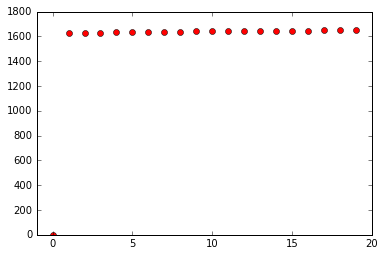

In [26]:
plt.plot(eigenvalue,'ro')
axes = plt.gca()
axes.set_xlim([-1,20])
plt.show()

In [27]:
def calScore():
    global rand
    global jaccard
    m11=0.0
    m00=0.0
    m01=0.0
    for i in range(data.shape[0]):
        for j in range(data.shape[0]):
            if data_truth[i]==data_truth[j] and cluster_assignment[i]==cluster_assignment[j]:
                m11 += 1
            elif data_truth[i]!=data_truth[j] and cluster_assignment[i]!=cluster_assignment[j]:
                m00 += 1
            else:
                m01 += 1
    rand = (m11+m00)/(m11+m00+m01)
    jaccard = (m11)/(m11+m01)

In [28]:
#kmeans
#initial random centroid assignment
iterations_output = 0
rand_output = 0
jaccard_output = 0
while iterations_output!=20:
    iterations_output += 1
    centroids = np.asarray(random.sample(v,  n_clusters))
    iterations = 0
    while True and iterations!=1000:
        iterations +=1
        centroids_old = centroids.copy()

        centroid_distance = distance.cdist(v, centroids, 'euclidean')
        cluster_assignment = np.argmin(centroid_distance,axis=1)
        for i in range(n_clusters):
            cluster = v[cluster_assignment==i]
            centroids[i] = cluster.mean(axis=0)

        if np.array_equal(centroids,centroids_old):
            break
    calScore()
    if rand > rand_output:
        rand_output = rand
        jaccard_output = jaccard
        cluster_assignment_output = cluster_assignment.copy()
        centroids_output = centroids.copy()

In [29]:
print "Rand Score:\t", rand_output
print "Jaccard Score:\t", jaccard_output

Rand Score:	0.540669462642
Jaccard Score:	0.118579089819


In [30]:
#Dimensionality reduction using PCA on data points
pca = PCA(n_components=2)
pca.fit(data_genes)
pca_output = pca.transform(data_genes)

#Dimensionality reduction using PCA on centroids calculated using kmeans
pca_c = PCA(n_components=2)
pca_c.fit(centroids_output)
pca_output_c = pca_c.transform(centroids_output)

#Dimensionality reduction using PCA on centroids calculated using ground truth
centroids_ground = np.zeros((n_clusters,data_genes.shape[1]))
for i in range(1,n_clusters+1):
    centroids_ground[i-1] = data_genes[data_truth==i].mean(axis=0)
pca_c_g = PCA(n_components=2)
pca_c_g.fit(centroids_ground)
pca_output_c_g = pca_c_g.transform(centroids_ground)

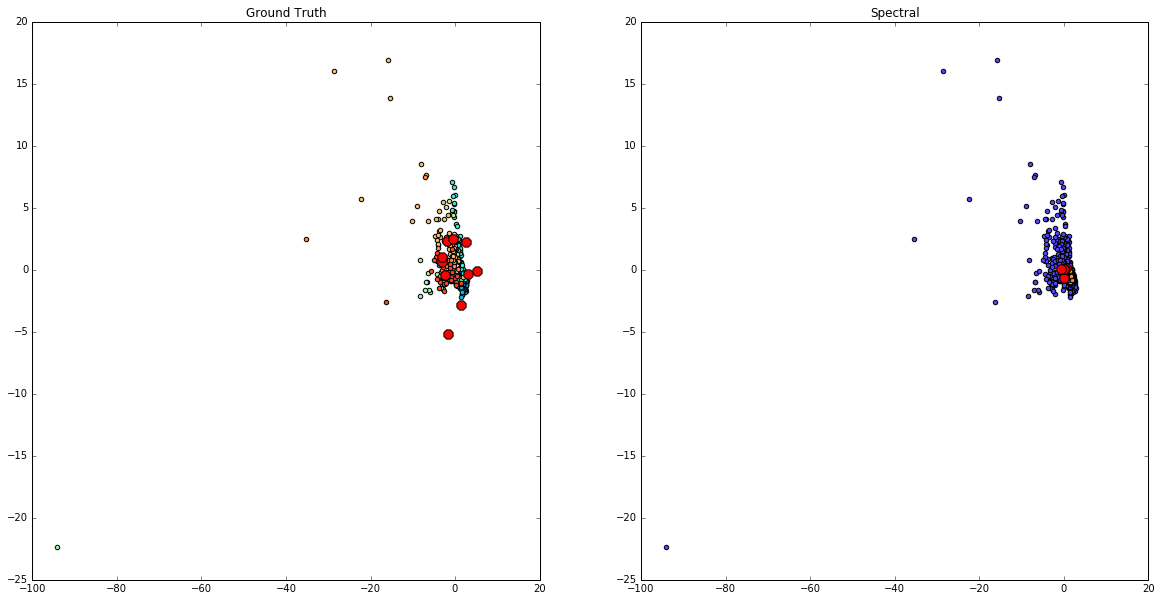

In [33]:
#Plotting ground truth and kmeans clustering results
fig = plt.figure(num=None, figsize=(20, 10), dpi=96, facecolor='w', edgecolor='k')

#10 colour rainbow generation shamelessly copied
# reference
# http://stackoverflow.com/questions/12236566/setting-different-color-for-each-series-in-scatter-plot-on-matplotlib
x = np.arange(n_clusters+2)
ys = [i+x+(i*x)**2 for i in range(n_clusters+2)]
colors = cm.rainbow(np.linspace(0, 1, len(ys)))
    
plt.subplot(121)
for i in range(1,n_clusters+1):
    plt.scatter(pca_output[data_truth==i][:,0],pca_output[data_truth==i][:,1],c=colors[i])
#plt.scatter(pca_output[data_truth==-1][:,0],pca_output[data_truth==-1][:,1],c=colors[0])
plt.scatter(pca_output_c_g[:,0],pca_output_c_g[:,1],c=colors[n_clusters+1],marker='8',s=100)
plt.title('Ground Truth')
#axes = plt.gca()
#axes.set_xlim([-20,20])
#axes.set_ylim([-20,20])
#plt.legend(['','','','','','','','','','','','centroid'],loc=3)

plt.subplot(122)
for i in range(n_clusters):
    plt.scatter(pca_output[cluster_assignment==i][:,0],pca_output[cluster_assignment==i][:,1],c=colors[i])
plt.scatter(pca_output_c[:,0],pca_output_c[:,1],c=colors[n_clusters+1],marker='8',s=100)
plt.title('Spectral')
#axes = plt.gca()
#axes.set_xlim([-20,20])
#axes.set_ylim([-20,20])
#plt.legend(['','','','','','','','','','','centroid'],loc=3)
plt.show()